# Part 3.2 Building a model

In [1]:
from ipynb.fs.defs.p1_data_prep import load_dataset

In [2]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

Load datasets for training and validation

In [3]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)

Finished reading the dataset
Finished reading the dataset


Display a few examples from both classes

(5216, 150, 150, 3)


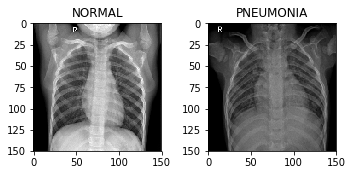

In [4]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)])

plt.tight_layout()

We're going to load VGG16 model with pre-trained ImageNet weights.

![](./assets/vgg16.png)

Next, we'll replace the orignal classification layer and build a new one:)

**Excercise 3.1.** Construct a new model in Keras

It should be composed of:

- Base model VGG16 with input shape 150 x 150 x 3
- Flatten transformation that reshapes last MaxPool layer (4 x 4 x 512) into (1 x 1 x 8192)
- Fully Connected Dense layer with Softmax activation function with 2 outputs (1 x 1 x 2)

In [25]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

K.clear_session()

NUM_CLASSES = 2

### Your input bellow
base_model = VGG16(weights = 'imagenet', input_shape=(150, 150, 3), include_top=False)
x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# base_model.summary()

Softmax function normalizes input vector into a probability distribution that sums to 1.0

The new network has over 14M trainable wegihts.

In [26]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

We would like to train only the most bottom classifier layers.

In [27]:
model = Model(inputs=base_model.input, outputs=x)

In [28]:
for layer in model.layers[0:20]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: False
layer 20: dense_1, trainable: True


In [29]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 2) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32_ref>]

By locking the trainable layers we decrease ammount of trainable parameters to 16'384.

Let's compile the model. We want to try first with RMSProp optimizer.

Here we use the "cross-entropy" as Loss function, which works well for learning probability distributions for classification. 

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy

In [30]:
optimizer = keras.optimizers.RMSprop()

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [31]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

The training set is un-balanaced. Let's calculate class weights

In [32]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [33]:
# prepare a directory to store the model weights
shutil.rmtree('./model')
os.makedirs('./model', exist_ok=True)

# fit the model
history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[checkpoint],
    shuffle=True,
    batch_size=64,
    epochs=20,
    verbose=1
)

Train on 3651 samples, validate on 1565 samples
Epoch 1/20
3651/3651 [==============================] - 23s 6ms/step - loss: 2.2571 - acc: 0.8381 - val_loss: 0.7733 - val_acc: 0.9399

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/20
3651/3651 [==============================] - 19s 5ms/step - loss: 0.6888 - acc: 0.9433 - val_loss: 0.2470 - val_acc: 0.9796

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/20
3651/3651 [==============================] - 19s 5ms/step - loss: 0.5349 - acc: 0.9554 - val_loss: 0.8038 - val_acc: 0.9323

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/20
3651/3651 [==============================] - 19s 5ms/step - loss: 0.4250 - acc: 0.9660 - val_loss: 0.0361 - val_acc: 0.9974

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/20
3651/3651 [==============================] - 19s 5ms/step - loss: 0.3963 - acc: 0.9674 - val_loss: 0.9549 - val_acc: 0.9233

Epoch 00005: saving model to model/weights.e

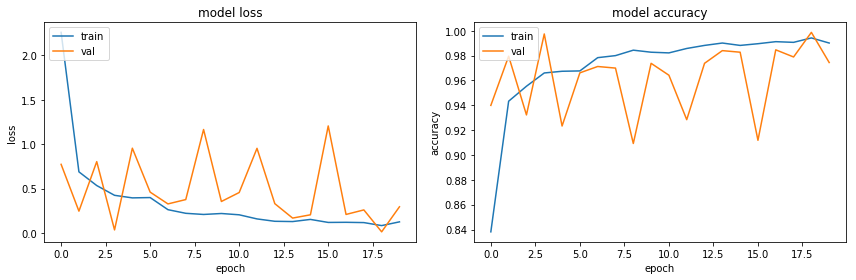

In [34]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

**Restore the best model** - find an epoch with minimal Loss on the validation dataset

In [35]:
idx = np.argmin(history.history['val_loss']) 
model.load_weights("model/weights.epoch_{:02d}.hdf5".format(idx + 1))

print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

Loading the best model
epoch: 19, val_loss: 0.014530539664991467, val_acc: 0.9987220447284345


Measure Loss and Accuracy on the test dataset

In [36]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 4.787042704530259, Accuracy: 0.6939102564102564


Plot confusion matrix

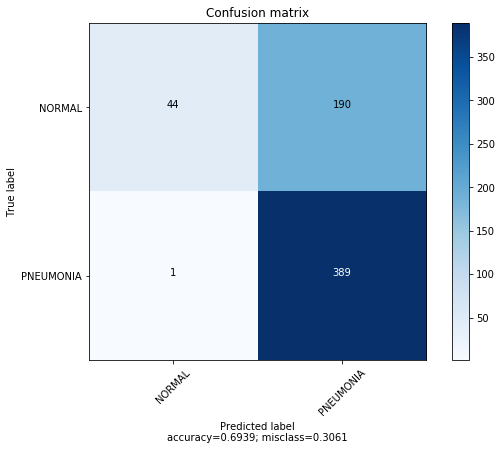

In [37]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

... and ROC curve

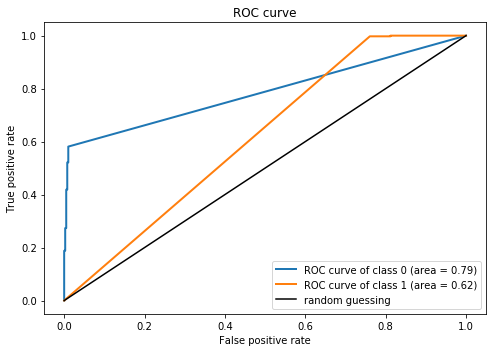

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

Let's check the performance metrics when the test set is ballanced (the same number of examples in both classes)

We need to under sample

(468, 67500)
(468,)
(468, 150, 150, 3)
(468, 2)


Text(0.5,1,'TEST (undersampled)')

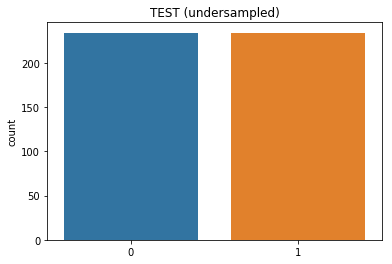

In [47]:
from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical

rus = RandomUnderSampler(random_state=42)

x_test_flat_shape = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
x_test_flat = x_test.reshape(x_test.shape[0], x_test_flat_shape)

y_test_flat = np.argmax(y_test, axis=1)

x_res, y_res = rus.fit_resample(x_test_flat, y_test_flat)

print(x_res.shape)
print(y_res.shape)

y_test_rus = to_categorical(y_res, num_classes = 2)

for i in range(len(x_res)):
    height, width, channels = 150, 150, 3
    x_test_rus = x_res.reshape(len(x_res), height, width, channels)
    
print(x_test_rus.shape)
print(y_test_rus.shape)

sns.countplot(np.argmax(y_test_rus, axis=1)).set_title('TEST (undersampled)')

In [48]:
score = model.evaluate(x_test_rus, y_test_rus, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 6.380404534502933, Accuracy: 0.594017094017094


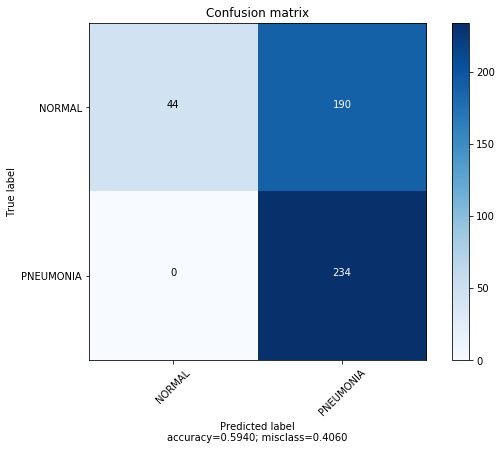

In [49]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test_rus)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test_rus, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

In 50:50 case the accuracy is lower

**Excercise 3.1.** We would like to achive a better performance on the test dataset. Try tuning hyperparameters i.e. learning rate. Can you reach better accuracy?

**Excercise 3.2.** Try to use another base network i.e. InceptionV3, ResNet50, DenseNet.

What do you observe? Is training time different? How many parameters does the function have?

**Excercise 3.3.** Try augmenting the training data using ImageDataGenerator from Keras. Introduce random rotation and image flips. Does this help?

**Excercise 3.4.** Try training some of the conv layers. Does this help?

**Excercise 3.5.** can you think about a better metric than accuracy, which captures the fact that false negatives are much (much) worse than false positives?

In [44]:
x2 = base_model.output
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dense(NUM_CLASSES, activation='softmax')(x2)

model2 = Model(inputs=base_model.input, outputs=x2)

for layer in model2.layers[0:20]:
    layer.trainable = False
    
optimizer = keras.optimizers.RMSprop()

model2.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [45]:
# fit the model
history2 = model2.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[checkpoint],
    shuffle=True,
    batch_size=64,
    epochs=20,
    verbose=1
)

Train on 3651 samples, validate on 1565 samples
Epoch 1/20
3651/3651 [==============================] - 20s 6ms/step - loss: 0.6107 - acc: 0.8970 - val_loss: 0.5202 - val_acc: 0.9847

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/20
3651/3651 [==============================] - 20s 5ms/step - loss: 0.5566 - acc: 0.9236 - val_loss: 0.4742 - val_acc: 0.8984

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/20
3651/3651 [==============================] - 20s 5ms/step - loss: 0.5072 - acc: 0.9471 - val_loss: 0.4002 - val_acc: 0.9444

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/20
3651/3651 [==============================] - 20s 5ms/step - loss: 0.4663 - acc: 0.9529 - val_loss: 0.3520 - val_acc: 0.9534

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/20
3651/3651 [==============================] - 20s 5ms/step - loss: 0.4275 - acc: 0.9630 - val_loss: 0.3029 - val_acc: 0.9834

Epoch 00005: saving model to model/weights.e

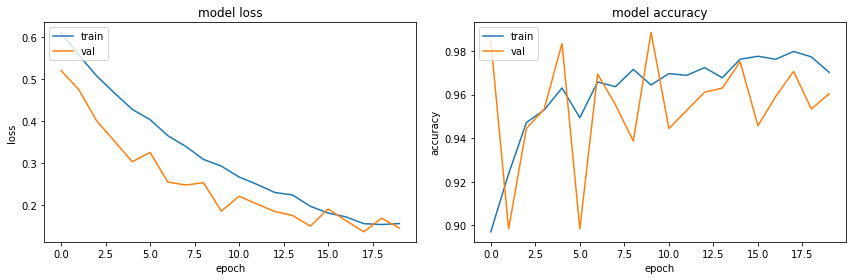

In [46]:
plot_learning_curves(history2)

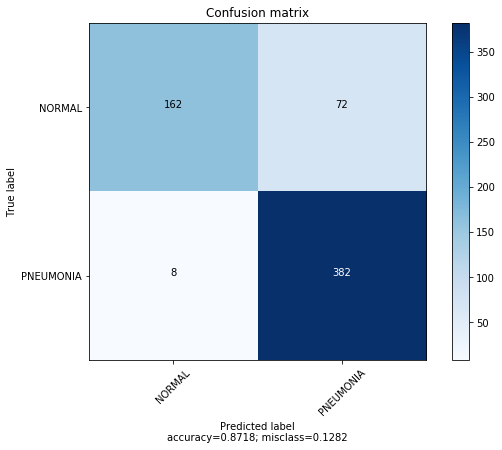

In [50]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model2.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

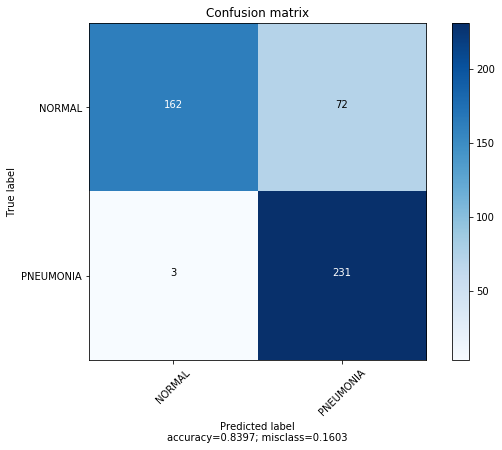

In [51]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model2.predict(x_test_rus)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test_rus, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
print('UNBALANCED - 1L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))
score = model.evaluate(x_test_rus, y_test_rus, verbose=0)
print('BALANCED - 1L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

UNBALANCED - 1L_Model Loss: 4.787042704530259, Accuracy: 0.6939102564102564
BALANCED - 1L_Model Loss: 6.380404534502933, Accuracy: 0.594017094017094


In [56]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('UNBALANCED - 2L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))
score = model2.evaluate(x_test_rus, y_test_rus, verbose=0)
print('BALANCED - 2L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

UNBALANCED - 2L_Model Loss: 0.41821338198123836, Accuracy: 0.8717948717948718
BALANCED - 2L_Model Loss: 0.513938874260992, Accuracy: 0.8397435897435898


In [57]:
x3 = base_model.output
x3 = Flatten()(x3)
x3 = Dense(1024, activation='relu')(x3)
x3 = Dense(NUM_CLASSES, activation='softmax')(x3)

model3 = Model(inputs=base_model.input, outputs=x3)

for layer in model3.layers[0:20]:
    layer.trainable = False
    
optimizer = keras.optimizers.RMSprop()

model3.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [58]:
# fit the model
history3 = model3.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[checkpoint],
    shuffle=True,
    batch_size=64,
    epochs=20,
    verbose=1
)

Train on 3651 samples, validate on 1565 samples
Epoch 1/20
3651/3651 [==============================] - 20s 6ms/step - loss: 2.8052 - acc: 0.8206 - val_loss: 1.9287 - val_acc: 0.8792

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/20
3651/3651 [==============================] - 20s 5ms/step - loss: 2.2310 - acc: 0.8592 - val_loss: 1.3192 - val_acc: 0.9163

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/20
3651/3651 [==============================] - 20s 5ms/step - loss: 1.4935 - acc: 0.9066 - val_loss: 0.0103 - val_acc: 0.9994

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/20
3651/3651 [==============================] - 20s 5ms/step - loss: 2.3984 - acc: 0.8510 - val_loss: 2.8524 - val_acc: 0.8198

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/20
3651/3651 [==============================] - 20s 5ms/step - loss: 1.5008 - acc: 0.9055 - val_loss: 1.6333 - val_acc: 0.8978

Epoch 00005: saving model to model/weights.e

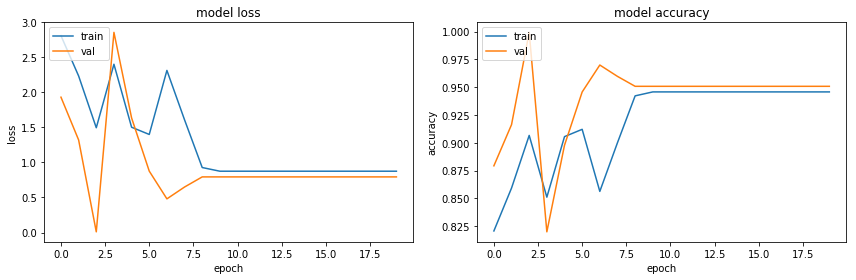

In [59]:
plot_learning_curves(history3)

In [60]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('UNBALANCED - RELU-2L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))
score = model3.evaluate(x_test_rus, y_test_rus, verbose=0)
print('BALANCED - RELU-2L_Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

UNBALANCED - RELU-2L_Model Loss: 3.190890155225183, Accuracy: 0.8012820512820513
BALANCED - RELU-2L_Model Loss: 4.1511990769296645, Accuracy: 0.7414529914529915
